# Antarctica Mesh

In [1]:
# set python to pick up local directory
from pathlib import Path
import sys
import os
path_root = str(Path(os.getcwd()).parents[0])
package_root = str(Path(os.getcwd()).parents[1])
sys.path.append(path_root)
sys.path.append(package_root)

# auto reload
%reload_ext autoreload
%autoreload 2

# hush
import warnings
warnings.simplefilter('always', category=FutureWarning)

In [2]:
from jax import config
config.update("jax_enable_x64", True)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

In [4]:
import jax
import jax.numpy as jnp
from jax.lib import xla_bridge
import equinox as eqx
from tensorflow_probability.substrates.jax import distributions as tfd
import jaxopt, optax
from tinygp.kernels.stationary import ExpSquared

import pyvista as pv
import jraph

pv.global_theme.trame.server_proxy_enabled = True
pv.start_xvfb(wait=2)

In [5]:
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [6]:
from emmd.utils import grid
from emmd.mmd import ImpCloudMMD, ScoreMMD, ergodic_metric
from emmd.transforms import Transform, ARD, DeepCK, MultiDeepCK
from emmd.kernels import RFF
from emmd.train import train_mmd_kernel, \
    train_mmd, train_mmd_kernel_gp, train_mmd_kernel_score
from emmd.gp import gp_pred
from emmd.mesh import o3d_mesh_to_pv, o3d_mesh_to_graph, knn_graph, trajectory_graph, \
    plot_3d_trajectory_pv, point_in_mesh_fn, plot_multi_3d_traj_pv, downsample_o3d_mesh, traj_to_line

In [7]:
jax.clear_caches()
print(f"device: {xla_bridge.get_backend().platform}")

device: gpu


In [8]:
key = jax.random.PRNGKey(0)

## Data

In [132]:
def min_max_scale(x):
    return (x - x.min()) / (x.max() - x.min())

ant = pv.examples.download_antarctica_velocity()
ant.points[:, :-1] = min_max_scale(ant.points[:, :-1])

ant_bounds = ant.bounds
ant_bounds = jnp.array(ant_bounds).reshape(3, 2).T
bounds = ant_bounds * 1.1
bounds = bounds[:, :-1]  # make 2d as nonexistent third dim

In [133]:
ant["magnitude"] = jnp.linalg.norm(ant["ssavelocity"], axis=1)
X_grid = grid(bounds, N=100, flatten=False)
X_flat = grid(bounds, N=100)

points = jnp.asarray(ant.points)[:, :-1]
velocity = jnp.asarray(ant.point_data['ssavelocity'])
magnitude = jnp.linalg.norm(velocity, axis=1)

n_samples = 5000
sample_inds = jax.random.choice(
    key, jnp.arange(len(points)), shape=(n_samples,), replace=False, p=magnitude / magnitude.sum()
)
samples = points[sample_inds]
sample_mag = magnitude[sample_inds]
# prob_s /= prob_s.max()

uni_sample_inds = jax.random.choice(key, jnp.arange(len(points)), shape=(n_samples,), replace=False)
uni_samples = points[uni_sample_inds]
uni_mag = magnitude[uni_sample_inds]

In [11]:
samples_plot = jnp.concatenate([samples, jnp.zeros((len(samples), 1))], axis=-1)

Sample according to magnitude

In [12]:
n_traj = 500
# traj_init = jnp.linspace(jnp.zeros(2), jnp.ones(2), num=n_traj, endpoint=True)
traj_init = jax.random.choice(key, samples, shape=(n_traj,), replace=False)
traj_init = traj_init[traj_init[:, 0].argsort()]

In [13]:
# def circle_init(midpt, radius):
#     theta = jnp.linspace(0, 2 * jnp.pi, num=n_traj)
#     x = midpt[0] + radius * jnp.cos(theta)
#     y = midpt[1] + radius * jnp.sin(theta)
#     return jnp.stack([x, y], axis=-1)
# traj_init = circle_init(jnp.array([0.5, 0.5]), 0.5)

In [14]:
# auxilary loss functions
def traj_loss_fn(particles):
    return jnp.mean(jnp.sum((particles[1:]-particles[:-1])**2, axis=1))

### Initial Metric and Plots

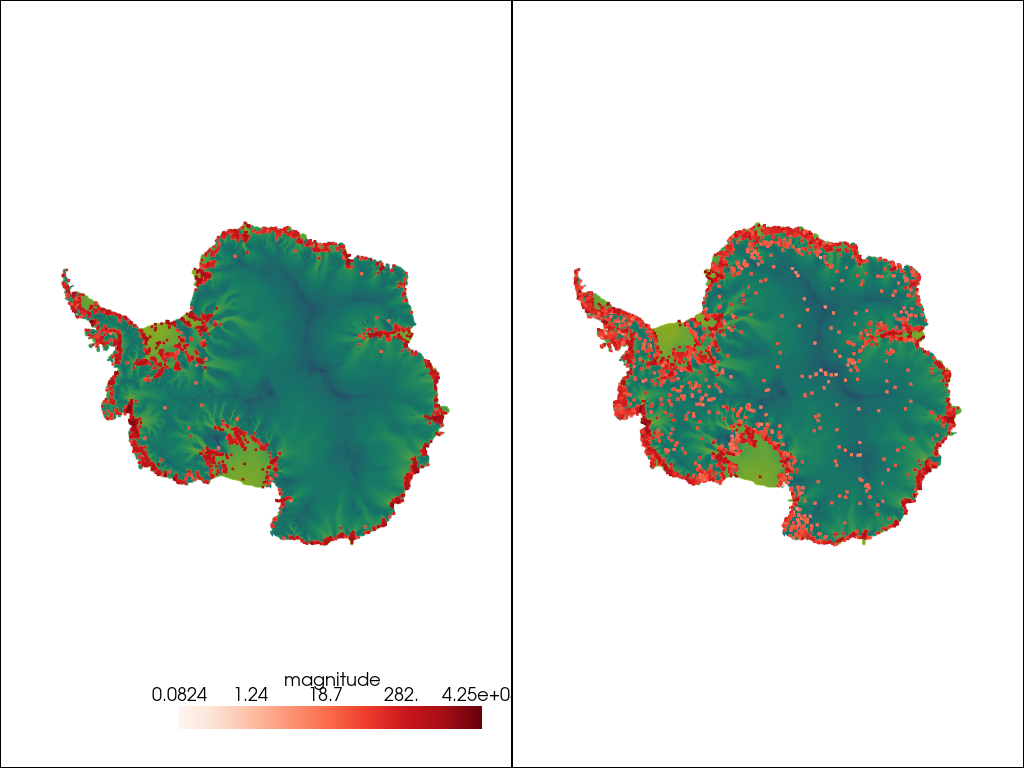

In [15]:
sample_pts = pv.PointSet(samples_plot)
sample_pts['magnitude'] = sample_mag

uni_pts = pv.PointSet(uni_plot)
uni_pts['magnitude'] = uni_mag

pl = pv.Plotter(notebook=True, shape=(1,2))
pl.subplot(0, 0)
vel_dargs = dict(scalars="magnitude", clim=[1e-3, 1e4], log_scale=True)
pl.add_mesh(ant, show_edges=False, **vel_dargs)
pl.add_points(sample_pts, scalars="magnitude", cmap="Reds", point_size=3, log_scale=True)
pl.view_xy()

pl.subplot(0,1)
vel_dargs = dict(scalars="magnitude", clim=[1e-3, 1e4], log_scale=True)
pl.add_mesh(ant, show_edges=False, **vel_dargs)
pl.add_points(uni_pts, scalars="magnitude", cmap="Reds", point_size=3, log_scale=True)
pl.show(cpos="xy", jupyter_backend='pythreejs')

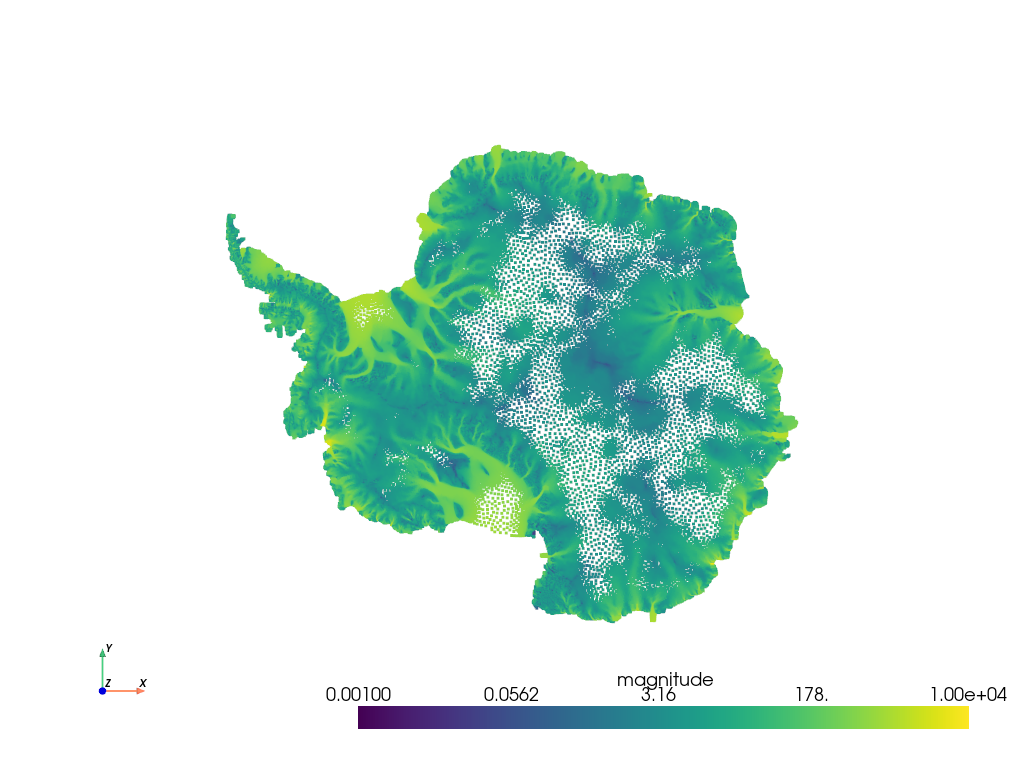

In [16]:
pv.PointSet(ant).plot(
    scalars="magnitude", clim=[1e-3, 1e4], cmap="viridis", point_size=3,
    cpos='xy', log_scale=True, jupyter_backend='pythreejs'
)

<Axes: ylabel='Count'>

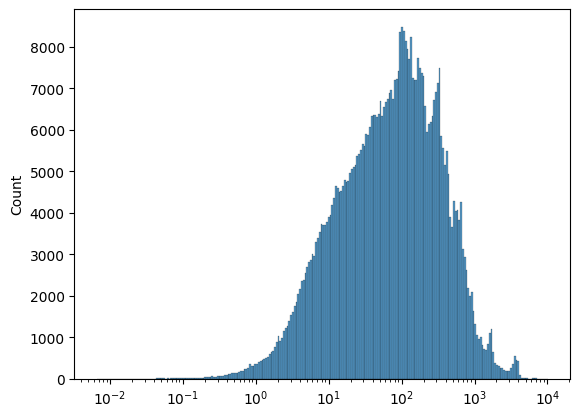

In [18]:
sns.histplot(magnitude, log_scale=True)

## Model Definitions

In [28]:
def train_rbf_kernels(
    key, traj_init, samples, prob_samples, bounds, 
    power_params, gp_params, score_params,
    **kwargs
):

    n_traj, d = traj_init.shape

    # initialize models
    ls_init = kwargs.get("ls", None)
    if ls_init is None:
        ls_init = (samples[:, None, :] - samples[None, :, :])**2
        ls_init = ls_init.reshape(-1, d)
        ls_init = jnp.sqrt(jnp.median(ls_init, axis=0))

    # initialize
    R = kwargs.get("R", 100)
    k_init = Transform(ARD(ls_init), ExpSquared())
    k_rff_init = Transform(ARD(ls_init), RFF(key, R=R, d=d))
    
    mmd_init = ImpCloudMMD(k_init, traj_init)
    mmd_rff_init = ImpCloudMMD(k_rff_init, traj_init)

    q = score_params.pop("q", "normal")
    q_params = score_params.pop("q_params", None)
    l = score_params.pop("l", None)
    mmd_score_init = ScoreMMD(key, k_init, traj_init, q=q, q_params=q_params, l=l)

    # power training
    print("Training power")
    mmd_power, power_loss = train_mmd_kernel(
        key, mmd_init, samples, to_train=lambda t: [t.k.transform.scale],
        **power_params
    )

    # gp training
    print("Training gp")
    mmd_gp, gp_loss = train_mmd_kernel_gp(
        key, mmd_rff_init, samples, prob_samples, to_train=lambda t: [t.k.transform.scale], 
        lowrank=True, **gp_params
    )

    # score training
    print("Training score")
    score_param_fn = lambda t: [t.k.transform.scale, t.z, t.q_params, t.l]
    mmd_score, _, score_loss = train_mmd_kernel_score(
        key, mmd_score_init, samples, to_train=score_param_fn, **score_params
    )

    return mmd_init, mmd_power, mmd_gp, mmd_score


In [29]:
def train_rff_kernels(
    key, traj_init, samples, prob_samples, bounds, 
    power_params, gp_params, score_params,
    **kwargs
):

    n_traj, d = traj_init.shape

    # initialize models
    ls_init = kwargs.get("ls", None)
    if ls_init is None:
        ls_init = (samples[:, None, :] - samples[None, :, :])**2
        ls_init = ls_init.reshape(-1, d)
        ls_init = jnp.sqrt(jnp.median(ls_init, axis=0))

    # initialize
    R = kwargs.get("R", 100)
    k_init = Transform(ARD(ls_init), RFF(key, R=R, d=d))    
    mmd_init = ImpCloudMMD(k_init, traj_init)

    q = score_params.pop("q", "normal")
    q_params = score_params.pop("q_params", None)
    l = score_params.pop("l", None)
    mmd_score_init = ScoreMMD(key, k_init, traj_init, q=q, q_params=q_params, l=l, R=R)

    # power training
    print("Training power")
    mmd_power, power_loss = train_mmd_kernel(
        key, mmd_init, samples, 
        to_train=lambda t: [t.k.kernel.w, t.k.transform.scale],
        **power_params
    )

    # gp training
    print("Training gp")
    mmd_gp, gp_loss = train_mmd_kernel_gp(
        key, mmd_init, samples, prob_samples, 
        to_train=lambda t: [t.k.kernel.w, t.k.transform.scale], 
        lowrank=True, **gp_params
    )

    # score training
    print("Training score")
    score_param_fn = lambda t: [
        t.k.kernel.w, t.k.transform.scale, t.z, t.q_params, t.l
    ]
    mmd_score, _, score_loss = train_mmd_kernel_score(
        key, mmd_score_init, samples, to_train=score_param_fn, **score_params
    )

    return mmd_init, mmd_power, mmd_gp, mmd_score


In [30]:
def train_deep_kernels(
    key, traj_init, samples, prob_samples, bounds, 
    power_params, gp_params, score_params,
    **kwargs
):

    n_traj, d = traj_init.shape

    # initialize models
    ls_init = kwargs.get("ls", None)
    if ls_init is None:
        ls_init = (samples[:, None, :] - samples[None, :, :])**2
        ls_init = ls_init.reshape(-1, d)
        ls_init = jnp.sqrt(jnp.median(ls_init, axis=0))

    # initialize
    R = kwargs.get("R", 100)
    n_hidden = kwargs.get("n_layers", 3)
    d_hidden = kwargs.get("d_hidden", 15)
    d_out = kwargs.get("out_dim", 8)
    n_kernels = kwargs.get("n_kernels", 3)
    k_init = MultiDeepCK(key, in_dim=d, out_dim=d_out, d_hidden=d_hidden, n_layers=n_hidden, n_kernels=n_kernels)
    mmd_init = ImpCloudMMD(k_init, traj_init)
    
    q = score_params.pop("q", "normal")
    q_params = score_params.pop("q_params", None)
    l = score_params.pop("l", None)
    mmd_score_init = ScoreMMD(key, k_init, traj_init, q=q, q_params=q_params, l=l)

    # power training
    training_param_fn = lambda t: [
        t.k.mdk, t.k.ck.scale#, t.k.epsilon
    ]

    print("Training power")
    mmd_power, power_loss = train_mmd_kernel(
        key, mmd_init, samples, 
        to_train=training_param_fn,
        **power_params
    )

    # gp training
    print("Training gp")
    mmd_gp, gp_loss = train_mmd_kernel_gp(
        key, mmd_init, samples, prob_samples, 
        to_train=training_param_fn,
        lowrank=False, **gp_params
    )

    # score training
    print("Training score")
    score_param_fn = lambda t: [
        t.k.mdk, t.k.ck.scale, t.k.epsilon, t.z, t.q_params, t.l
    ]
    mmd_score, _, score_loss = train_mmd_kernel_score(
        key, mmd_score_init, samples, to_train=score_param_fn, **score_params
    )

    # return mmd_init, mmd_power, mmd_score
    return mmd_init, mmd_power, mmd_gp, mmd_score


In [31]:
def train_trajectories(
        key, models, samples, bounds, aux_loss, 
        solver_params={}, use_adam=False, **kwargs
    ):

    if use_adam:
        def training_fn(model):
            return train_mmd(
                key, model, samples, aux_loss=aux_loss, optimizer="optax",
                **solver_params
            )

    else:
        def training_fn(model):
            return train_mmd(
                key, model, samples, bounds, aux_loss=aux_loss, 
                opt_params=solver_params
            )

    res = []
    for i, model in enumerate(models):
        print(f"Training model {i+1}")
        model_trained, _ = training_fn(model)
        res.append(model_trained)

    return res


## Run Models

In [32]:
epochs_k = 2000
epochs_mmd = 1000
lr = 1e-3

### RBF

In [33]:
rbf_power_params = {
    'epochs': epochs_k, 'lr': lr, 'verbose': False
}
rbf_gp_params = {
    "epochs": epochs_k, 'diag': 1e-3, 'lr': lr, 'verbose': False
}
rbf_score_params = {
    'lr': 1e-3, 'q': 'normal', #'q_params': bounds,
    'epochs': 2000, 'verbose': True
}

Train kernels:

In [34]:
rbf_init, rbf_power, rbf_gp, rbf_score = train_rbf_kernels(
    key, traj_init, samples, sample_mag, bounds, rbf_power_params, rbf_gp_params, rbf_score_params
)

Training power
Training gp
Training score
epoch 0,loss: 2080.2528811616367
epoch 50,loss: 23.757411871846536
epoch 100,loss: 6.819592190273523
epoch 150,loss: 1.8993090229308547
epoch 200,loss: -0.3894253656691875
epoch 250,loss: -1.9198744582805407
epoch 300,loss: -2.3177783776541303
epoch 350,loss: -3.6605407159813406
epoch 400,loss: -5.9501838725238745
epoch 450,loss: -11.475083693018966
epoch 500,loss: -34.54419603446398
epoch 550,loss: -101.32896620772593
epoch 600,loss: -172.49116451702
epoch 650,loss: -187.29562487433049
epoch 700,loss: -194.15080459896302
epoch 750,loss: -309.67725718215416
epoch 800,loss: -330.75345537039266
epoch 850,loss: -4566.392760175716
epoch 900,loss: -5375.96590250877
epoch 950,loss: -9703.481705539167
epoch 1000,loss: -10018.18521761466
epoch 1050,loss: -7954.464958088039
epoch 1100,loss: -15376.980082370748
epoch 1150,loss: -19884.473970413535
epoch 1200,loss: -22462.28978238416
epoch 1250,loss: -20497.381429448582
epoch 1300,loss: -15834.24617595419

In [35]:
rbf_models = (rbf_init, rbf_power, rbf_gp, rbf_score)

for model in rbf_models:
    print(f"Scale: {model.k.transform._scale}")

Scale: [0.29659848 0.20144782]
Scale: [1.35273532 0.659049  ]
Scale: [0.06734329 0.04555354]
Scale: [0.01965221 0.01796837]


Train trajectories with MMD:

In [36]:
rbf_traj_init, rbf_power_traj, rbf_gp_traj, rbf_score_traj = train_trajectories(
        key, rbf_models, samples, aux_loss=traj_loss_fn, bounds=None, #bounds=bounds,
        solver_params={'tol': 1e-5, 'maxiter': 10_000}, use_adam=False, 
        # solver_params={'epochs': 3000, 'lr': 1e-2, 'verbose': True}, use_adam=True
)
rbf_trajectories = (
    rbf_traj_init.w, rbf_power_traj.w, 
    rbf_gp_traj.w, rbf_score_traj.w
)

Training model 1
{'tol': 1e-05, 'maxiter': 10000}
Training model 2
{'tol': 1e-05, 'maxiter': 10000}
Training model 3
{'tol': 1e-05, 'maxiter': 10000}


2024-05-23 02:31:32.335070: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %dot.26 = f64[5000,5000]{1,0} dot(f64[5000,200]{1,0} %constant.78, f64[5000,200]{1,0} %constant.90), lhs_contracting_dims={1}, rhs_contracting_dims={1}, metadata={op_name="jit(loss_fn)/jit(main)/vmap(vmap(jit(evaluate)))/dot_general[dimension_numbers=(((1,), (1,)), ((), ())) precision=None preferred_element_type=float64]" source_file="/home/houston/devel/ergodic_mmd/emmd/kernels.py" source_line=83}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-05-23 02:31:38.916316: E external/xla/xla/service/slow_ope

Training model 4
{'tol': 1e-05, 'maxiter': 10000}


### RFF

In [15]:
rff_power_params = {
    'epochs': 3000, 'lr': 1e-3, 'verbose': False
}
rff_gp_params = {
    "epochs": 3000, 'diag': 1e-3, 'lr': 1e-3, 'verbose': True
}
rff_score_params = {
    'lr': 1e-3, 'q': 'normal',
    'epochs': 3000, 'verbose': True
}

In [72]:
rff_init, rff_power, rff_gp, rff_score = train_rff_kernels(
    key, traj_init, samples, sample_mag, bounds, rff_power_params, rff_gp_params, rff_score_params
)

Training power
Training gp
epoch 0,loss: 1474634005222.9026
epoch 50,loss: 1434105667989.147
epoch 100,loss: 1397954767220.307
epoch 150,loss: 1367373573169.1704
epoch 200,loss: 1344813754410.9038
epoch 250,loss: 1330115953094.1714
epoch 300,loss: 1318502520483.0305
epoch 350,loss: 1305570887797.98
epoch 400,loss: 1288625681595.5676
epoch 450,loss: 1269952902806.429
epoch 500,loss: 1256298944241.4097
epoch 550,loss: 1246289647651.1519
epoch 600,loss: 1236210796573.335
epoch 650,loss: 1221838001121.3389
epoch 700,loss: 1202122736995.1824
epoch 750,loss: 1192377998460.6135
epoch 800,loss: 1181936843933.6157
epoch 850,loss: 1163503797727.875
epoch 900,loss: 1144684058056.2795
epoch 950,loss: 1129990119563.4712
epoch 1000,loss: 1119689013578.182
epoch 1050,loss: 1111290993626.1729
epoch 1100,loss: 1101087491122.1687
epoch 1150,loss: 1089038439283.9836
epoch 1200,loss: 1073833050887.6421
epoch 1250,loss: 1057971869168.5481
epoch 1300,loss: 1046399423067.5862
epoch 1350,loss: 1038284688128.8

In [73]:
rff_models = (rff_init, rff_power, rff_gp, rff_score)

In [75]:
rff_traj_init, rff_power_traj, rff_gp_traj, rff_score_traj = train_trajectories(
        key, rff_models, samples, aux_loss=traj_loss_fn, bounds=None, #bounds=bounds
        solver_params={'tol': 1e-5, 'maxiter': 10_000}, use_adam=False, 
        # solver_params={'epochs': 5000, 'lr': 1e-2, 'verbose': True}, use_adam=True
)
rff_trajectories = (
    rff_traj_init.w, rff_power_traj.w, 
    rff_gp_traj.w, rff_score_traj.w
)

Training model 1
{'tol': 1e-05, 'maxiter': 10000}
Training model 2
{'tol': 1e-05, 'maxiter': 10000}
Training model 3
{'tol': 1e-05, 'maxiter': 10000}
Training model 4
{'tol': 1e-05, 'maxiter': 10000}


### Deep Kernel

In [55]:
deep_power_params = {
    'epochs': 1, 'lr': 1e-3, 'verbose': False
}
deep_gp_params = {
    "epochs": 1, 'diag': 1e-4, 'lr': 1e-3, 'verbose': True
}
deep_score_params = {
    'lr': 1e-2, 'q': 'uniform', 'q_params': standard_scale(bounds),
    'epochs': 1000, 'verbose': True
}

In [56]:
deep_init, deep_power, deep_gp, deep_score = train_deep_kernels(
    key, traj_init, samples_sc, sample_mag, bounds, deep_power_params, deep_gp_params, deep_score_params
)
deep_models = (deep_init, deep_power, deep_gp, deep_score)

Training power
Training gp
epoch 0,loss: 18756006996603.855
Training score
epoch 0,loss: -0.9318103138004042
epoch 50,loss: -1.1489758174699414
epoch 100,loss: -1.8870312040899375
epoch 150,loss: -4.132885821328969
epoch 200,loss: -10.081025994046131
epoch 250,loss: -18.89669778716241
epoch 300,loss: -2.6805306747903423
epoch 350,loss: -7.276248655851376
epoch 400,loss: -44.489388724398424
epoch 450,loss: -57.172559347662926
epoch 500,loss: -64.26254889355745
epoch 550,loss: -64.6192922417343
epoch 600,loss: -62.32183668459343
epoch 650,loss: -63.227749937108065
epoch 700,loss: -63.93777628365496
epoch 750,loss: -64.52523641471123
epoch 800,loss: -64.96774992362134
epoch 850,loss: -65.25386859138129
epoch 900,loss: -65.40935828788051
epoch 950,loss: -65.47138366602529


In [57]:
jnp.abs(gp_pred(deep_score.k, samples_sc, sample_mag, uni_sc)[0] - uni_mag).mean()

Array(452.28064685, dtype=float64)

In [61]:
deep_traj_trained = train_trajectories(
        # key, deep_models, samples_sc, aux_loss=traj_loss_fn, bounds=None, #bounds=bounds
        key, [deep_score], samples_sc, aux_loss=traj_loss_fn, bounds=None, #bounds=bounds
        # solver_params={'tol': 1e-5, 'maxiter': 20_000}, use_adam=False, 
        solver_params={'epochs': 2000, 'lr': 1e-2, 'verbose': True}, use_adam=True, opt=optax.sgd(1e-3)
)
deep_trajectories = [inv_scale(d.w) for d in deep_traj_trained]

Training model 1
epoch 0, mmd loss: 0.06974196624085993, aux loss: 3.9636282592891577e-05
epoch 100, mmd loss: 0.01098095249705433, aux loss: 0.000627666981181266
epoch 200, mmd loss: 0.00024748704621124773, aux loss: 0.0002408935641247282
epoch 300, mmd loss: 8.090688539430511e-05, aux loss: 0.00012206123257640061
epoch 400, mmd loss: 6.362491997491394e-05, aux loss: 0.00010333541693725508
epoch 500, mmd loss: 5.5414021724931026e-05, aux loss: 9.564212087983665e-05
epoch 600, mmd loss: 4.692636072611832e-05, aux loss: 8.572572822009333e-05
epoch 700, mmd loss: 4.1801360509130525e-05, aux loss: 8.142901356737351e-05
epoch 800, mmd loss: 3.624589985840032e-05, aux loss: 8.001320681444946e-05
epoch 900, mmd loss: 3.091421456313803e-05, aux loss: 7.815088614220444e-05
epoch 1000, mmd loss: 2.4375629887329886e-05, aux loss: 7.359042169417458e-05
epoch 1100, mmd loss: 2.1785591445389052e-05, aux loss: 7.267470648371622e-05
epoch 1200, mmd loss: 2.065359031933056e-05, aux loss: 7.18853051218

## Visualize

### RBF

In [83]:
traj_line1 = jnp.concatenate([rbf_trajectories[0], jnp.zeros((len(rbf_trajectories[0]), 1))], axis=-1)
line1 = traj_to_line(traj_line1, color=True)
traj_line2 = jnp.concatenate([rbf_trajectories[1], jnp.zeros((len(rbf_trajectories[1]), 1))], axis=-1)
line2 = traj_to_line(traj_line2, color=True)
traj_line3 = jnp.concatenate([rbf_trajectories[2], jnp.zeros((len(rbf_trajectories[2]), 1))], axis=-1)
line3 = traj_to_line(traj_line3, color=True)
traj_line4 = jnp.concatenate([rbf_trajectories[3], jnp.zeros((len(rbf_trajectories[3]), 1))], axis=-1)
line4 = traj_to_line(traj_line4, color=True)

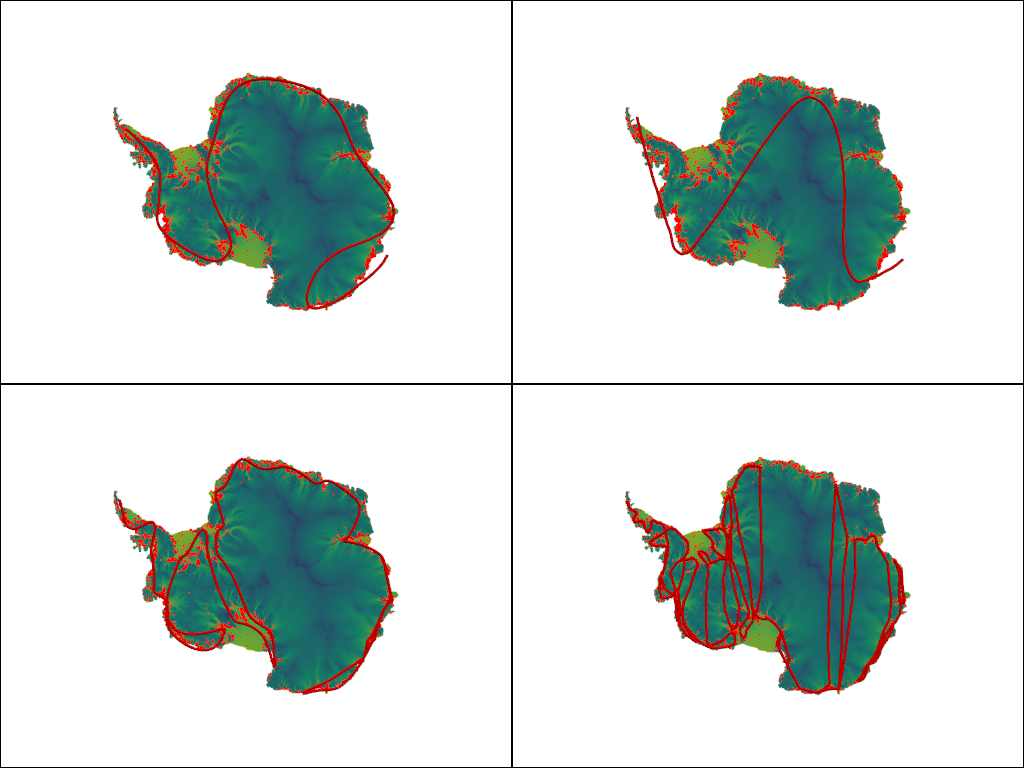

In [38]:
radius = 0.005
pl = pv.Plotter(notebook=True, shape=(2, 2))
vel_dargs = dict(scalars="magnitude", log_scale=True, show_scalar_bar=False)
line_args = {'smooth_shading': True, 'color': "red", 'show_scalar_bar': False}
point_args = {'color': "red", 'point_size': 1.5, 'log_scale': True, 'show_scalar_bar': False}

pl.subplot(0, 0)
pl.add_mesh(ant, show_edges=False, **vel_dargs)
tube1 = line1.tube(radius=radius)
pl.add_mesh(tube1, **line_args)
pl.add_points(pv.PointSet(samples_plot), **point_args)
pl.view_xy()

pl.subplot(0, 1)
pl.add_mesh(ant, show_edges=False, **vel_dargs)
tube2 = line2.tube(radius=radius)
pl.add_mesh(tube2, **line_args)
pl.add_points(pv.PointSet(samples_plot), **point_args)
pl.view_xy()

pl.subplot(1, 0)
pl.add_mesh(ant, show_edges=False, **vel_dargs)
tube3 = line3.tube(radius=radius)
pl.add_mesh(tube3, **line_args)
pl.add_points(pv.PointSet(samples_plot), **point_args)
pl.view_xy()

pl.subplot(1, 1)
pl.add_mesh(ant, show_edges=False, **vel_dargs)
tube4 = line4.tube(radius=radius)
pl.add_mesh(tube4, **line_args)
pl.add_points(pv.PointSet(samples_plot), **point_args)
pl.view_xy()

pl.show(jupyter_backend='pythreejs', cpos='xy')

In [47]:
samples_plot = samples_plot.at[:, -1].set(1e-5)

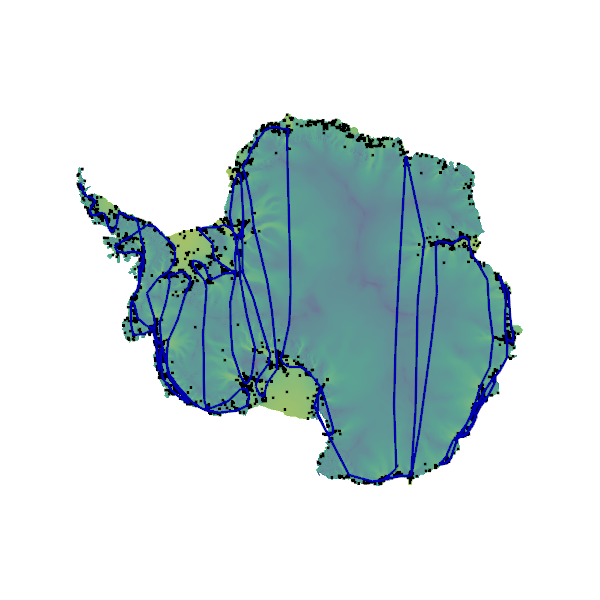

In [140]:
radius = 0.003
vel_dargs = dict(scalars="magnitude", log_scale=True, show_scalar_bar=False)
line_args = {'smooth_shading': True, 'color': "blue", 'show_scalar_bar': False}
point_args = {'color': "black", 'point_size': 3, 'log_scale': True, 'show_scalar_bar': False}



# pl.disable_parallel_projection()
pl = pv.Plotter(notebook=True, window_size=[600, 600])
pl.add_mesh(ant, opacity=0.7, show_edges=False, **vel_dargs)
pl.camera.zoom(1.5)

tube4 = line4.tube(radius=radius)
pl.add_mesh(tube4, **line_args)
pl.add_points(pv.PointSet(samples_plot), **point_args)
# pl.view_xy()

pl.show(jupyter_backend='pythreejs', cpos='xy', )

In [136]:
pl.camera.position = (0.5, 0.48662165739002805, 1.7)

(0.5, 0.48662165739002805, 2.516624689610768)

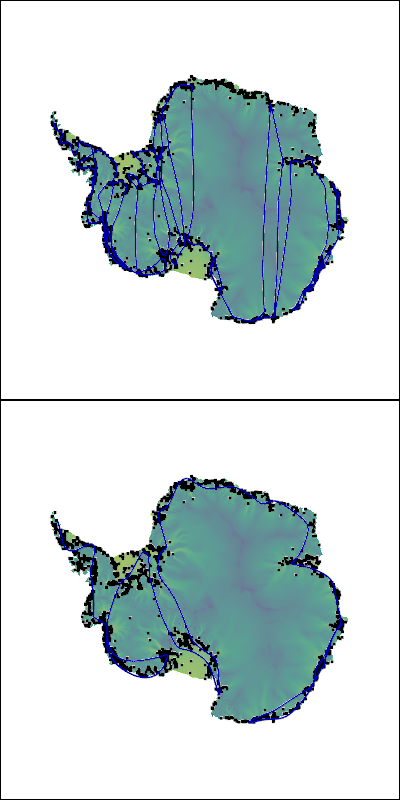

In [148]:
radius = 0.003
pl = pv.Plotter(notebook=True, shape=(2, 1), window_size=[400, 800])
vel_dargs = dict(scalars="magnitude", log_scale=True, show_scalar_bar=False)
line_args = {'smooth_shading': True, 'color': "blue", 'show_scalar_bar': False}
point_args = {'color': "black", 'point_size': 3, 'log_scale': True, 'show_scalar_bar': False}

pl.subplot(0, 0)
# pl.disable_parallel_projection()
pl.add_mesh(ant, opacity=0.7, show_edges=False, **vel_dargs)
tube4 = line4.tube(radius=radius)
pl.add_mesh(tube4, **line_args)
pl.add_points(pv.PointSet(samples_plot), **point_args)
pl.view_xy()
# pl.camera.zoom(1.5)

pl.subplot(1, 0)
pl.reset_camera()
pl.add_mesh(ant, opacity=0.7, show_edges=False, **vel_dargs)
tube3 = line3.tube(radius=radius)
pl.add_mesh(tube3, **line_args)
pl.add_points(pv.PointSet(samples_plot), **point_args)
pl.camera.zoom(1.5)
# pl.view_xy()

pl.camera.zoom(1.5)
pl.show(jupyter_backend='pygany', cpos='xy', )
pl.save_graphic('ant.pdf')

{'_parallel_projection': False,
 '_elevation': 0.0,
 '_azimuth': 0.0,
 '_is_set': True,
 '_renderer': <weakproxy at 0x7f6e123cf470 to Renderer at 0x7f6e6317ee00>}

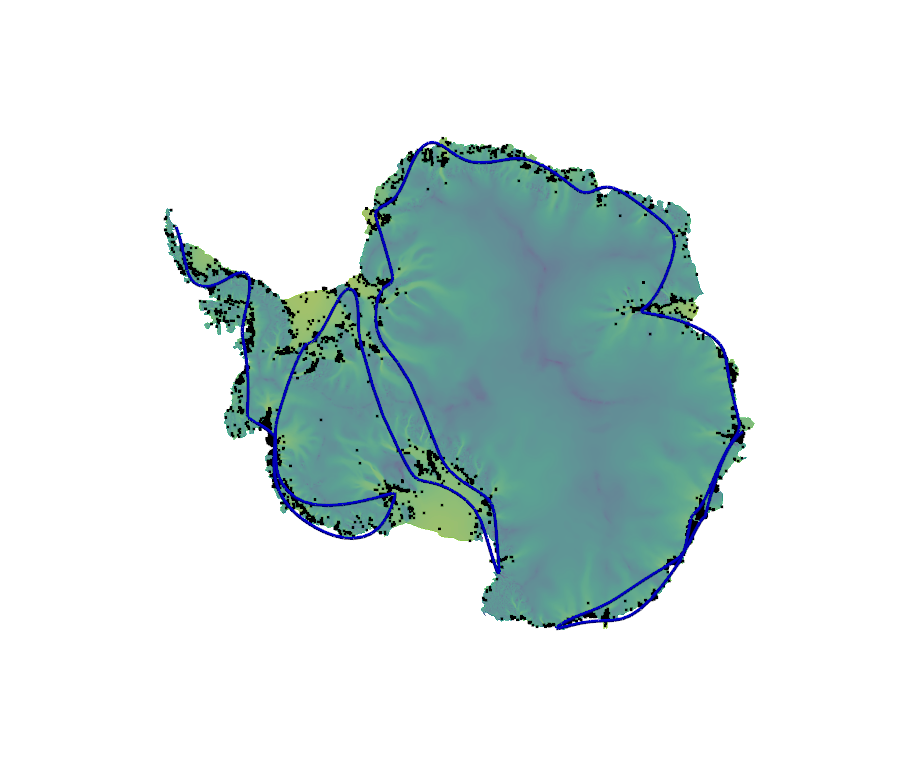

In [53]:
radius = 0.003
pl = pv.Plotter(notebook=True)
vel_dargs = dict(scalars="magnitude", log_scale=True, show_scalar_bar=False)
line_args = {'smooth_shading': True, 'color': "blue", 'show_scalar_bar': False}
point_args = {'color': "black", 'point_size': 3, 'log_scale': True, 'show_scalar_bar': False}

### RFF

In [76]:
traj_line1 = jnp.concatenate([rff_trajectories[0], jnp.zeros((len(rff_trajectories[0]), 1))], axis=-1)
line1 = traj_to_line(traj_line1, color=True)
traj_line2 = jnp.concatenate([rff_trajectories[1], jnp.zeros((len(rff_trajectories[1]), 1))], axis=-1)
line2 = traj_to_line(traj_line2, color=True)
traj_line3 = jnp.concatenate([rff_trajectories[2], jnp.zeros((len(rff_trajectories[2]), 1))], axis=-1)
line3 = traj_to_line(traj_line3, color=True)
traj_line4 = jnp.concatenate([rff_trajectories[3], jnp.zeros((len(rff_trajectories[3]), 1))], axis=-1)
line4 = traj_to_line(traj_line4, color=True)

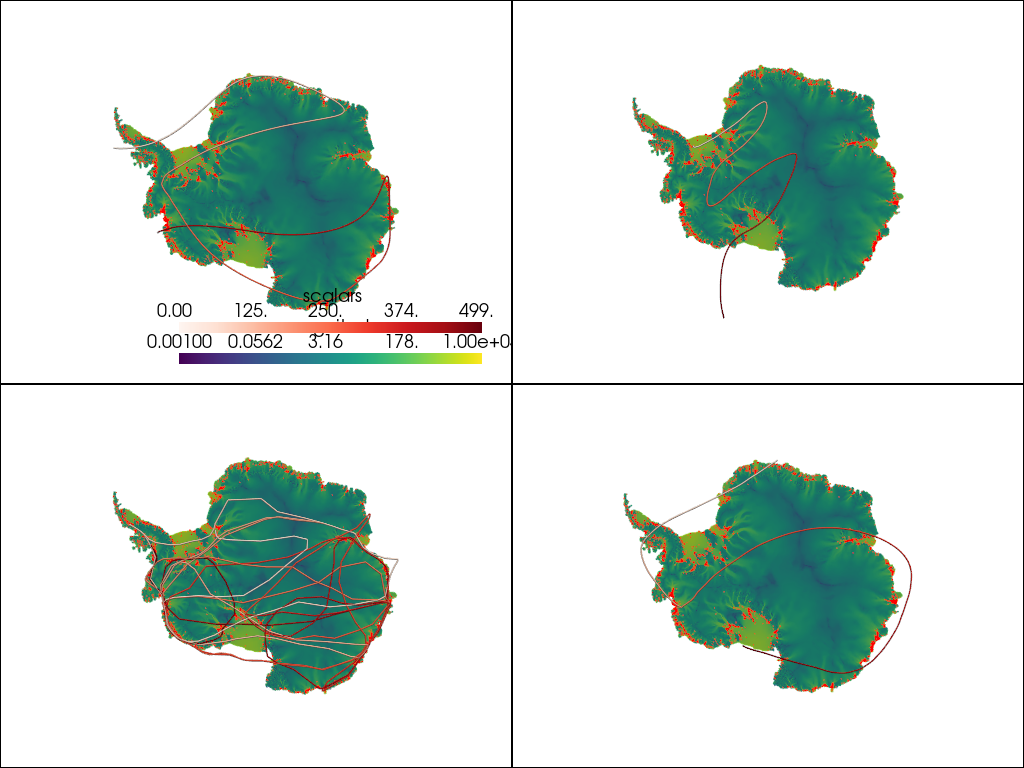

In [49]:
radius = 0.005
pl = pv.Plotter(notebook=True, shape=(2, 2))
vel_dargs = dict(scalars="magnitude", log_scale=True, show_scalar_bar=False)
line_args = {'smooth_shading': True, 'color': "red", 'show_scalar_bar': False}
point_args = {'color': "red", 'point_size': 1.5, 'log_scale': True, 'show_scalar_bar': False}

pl.subplot(0, 0)
pl.add_mesh(ant, show_edges=False, **vel_dargs)
tube1 = line1.tube(radius=radius)
pl.add_mesh(tube1, **line_args)
pl.add_points(pv.PointSet(samples_plot), **point_args)
pl.view_xy()

pl.subplot(0, 1)
pl.add_mesh(ant, show_edges=False, **vel_dargs)
tube2 = line2.tube(radius=radius)
pl.add_mesh(tube2, **line_args)
pl.add_points(pv.PointSet(samples_plot), **point_args)
pl.view_xy()

pl.subplot(1, 0)
pl.add_mesh(ant, show_edges=False, **vel_dargs)
tube3 = line3.tube(radius=radius)
pl.add_mesh(tube3, **line_args)
pl.add_points(pv.PointSet(samples_plot), **point_args)
pl.view_xy()

pl.subplot(1, 1)
pl.add_mesh(ant, show_edges=False, **vel_dargs)
tube4 = line4.tube(radius=radius)
pl.add_mesh(tube4, **line_args)
pl.add_points(pv.PointSet(samples_plot), **point_args)
pl.view_xy()

pl.show(jupyter_backend='pythreejs', cpos='xy')

### Deep Kernels

In [62]:
traj_line1 = jnp.concatenate([deep_trajectories[0], jnp.zeros((len(deep_trajectories[0]), 1))], axis=-1)
line1 = traj_to_line(traj_line1, color=True)
# traj_line2 = jnp.concatenate([deep_trajectories[1], jnp.zeros((len(deep_trajectories[1]), 1))], axis=-1)
# line2 = traj_to_line(traj_line2, color=True)
# traj_line3 = jnp.concatenate([deep_trajectories[2], jnp.zeros((len(deep_trajectories[2]), 1))], axis=-1)
# line3 = traj_to_line(traj_line3, color=True)
# traj_line4 = jnp.concatenate([deep_trajectories[3], jnp.zeros((len(deep_trajectories[3]), 1))], axis=-1)
# line4 = traj_to_line(traj_line4, color=True)

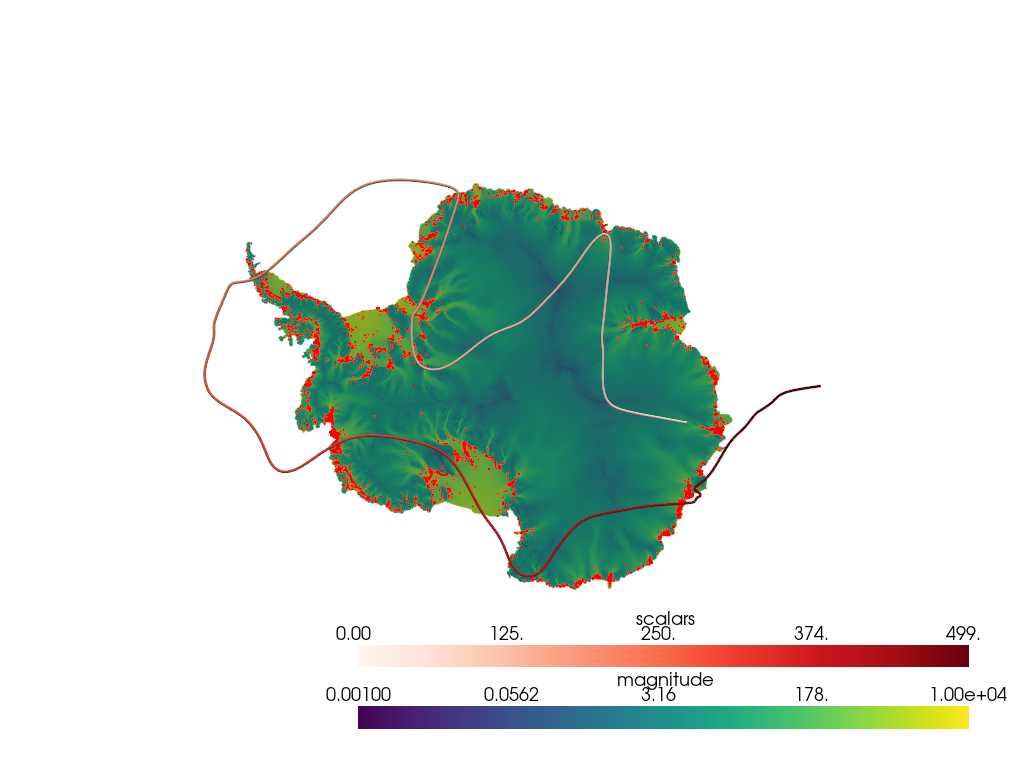

In [63]:
pl = pv.Plotter(notebook=True)
radius = 15_000
vel_dargs = dict(scalars="magnitude", clim=[1e-3, 1e4], log_scale=True)
# pl.subplot(0, 2)
pl.add_mesh(ant, show_edges=False, **vel_dargs)
tube1 = line1.tube(radius=radius)
pl.add_mesh(tube1, smooth_shading=True, cmap="Reds")
pl.add_points(pv.PointSet(sample_plot), color="red", point_size=2, log_scale=True)
pl.show(jupyter_backend='pythreejs', cpos='xy')

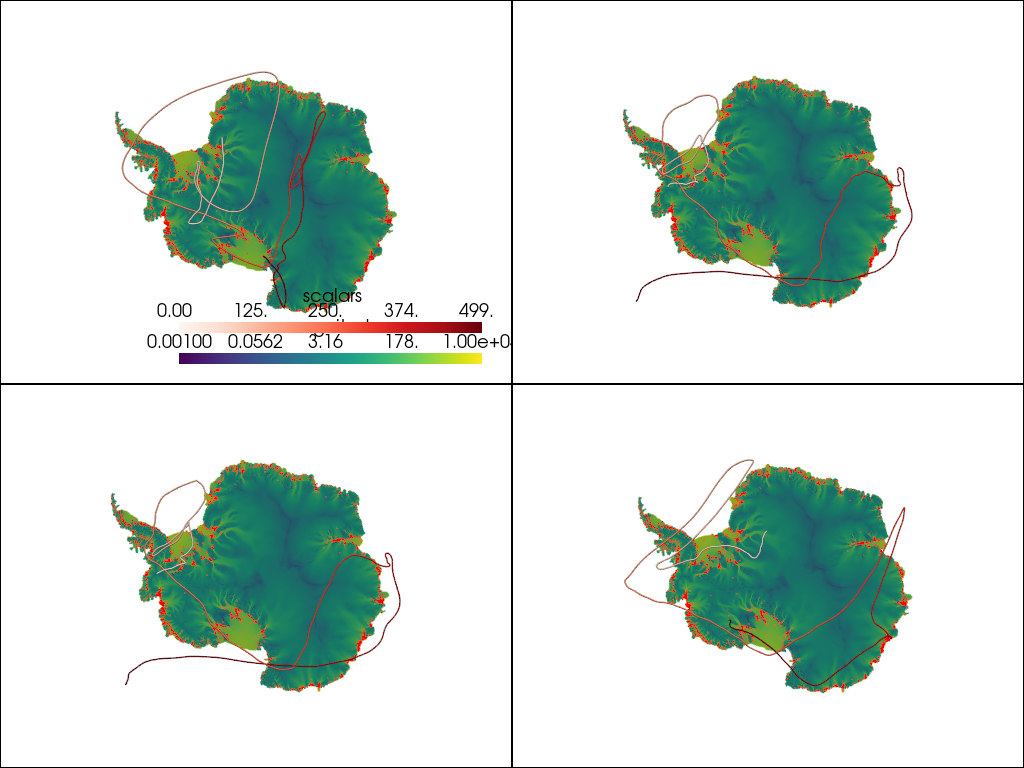

In [41]:
radius = 15_000
pl = pv.Plotter(notebook=True, shape=(2, 2))
# pl = pv.Plotter(notebook=True, shape=(1, 3))
vel_dargs = dict(scalars="magnitude", clim=[1e-3, 1e4], log_scale=True)

pl.subplot(0, 0)
# pl.subplot(0, 0)
pl.add_mesh(ant, show_edges=False, **vel_dargs)
tube1 = line1.tube(radius=radius)
pl.add_mesh(tube1, smooth_shading=True, cmap="Reds")
pl.add_points(pv.PointSet(sample_plot), color="red", point_size=1, log_scale=True)
pl.view_xy()

pl.subplot(0, 1)
# pl.subplot(0, 1)
pl.add_mesh(ant, show_edges=False, **vel_dargs)
tube2 = line2.tube(radius=radius)
pl.add_mesh(tube2, smooth_shading=True, cmap="Reds")
pl.add_points(pv.PointSet(sample_plot), color="red", point_size=1, log_scale=True)
pl.view_xy()

pl.subplot(1, 0)
# pl.subplot(0, 2)
pl.add_mesh(ant, show_edges=False, **vel_dargs)
tube3 = line3.tube(radius=radius)
pl.add_mesh(tube3, smooth_shading=True, cmap="Reds")
pl.add_points(pv.PointSet(sample_plot), color="red", point_size=1, log_scale=True)
pl.view_xy()

pl.subplot(1, 1)
pl.add_mesh(ant, show_edges=False, **vel_dargs)
tube4 = line4.tube(radius=radius)
pl.add_mesh(tube4, smooth_shading=True, cmap="Reds")
pl.add_points(pv.PointSet(sample_plot), color="red", point_size=1, log_scale=True)
pl.view_xy()

pl.show(jupyter_backend='pythreejs', cpos='xy')

## Metrics

In [105]:
def mse(x, y):
    return jnp.mean((x-y)**2)

### RBF

In [24]:
rbf_init_erg = ergodic_metric(rbf_traj_init.w, bounds, n_modes=20, n_per_dim=60)
rbf_power_erg = ergodic_metric(rbf_power_traj.w, bounds, n_modes=20, n_per_dim=60)
rbf_gp_erg = ergodic_metric(rbf_gp_traj.w, bounds, n_modes=20, n_per_dim=60)
rbf_score_erg = ergodic_metric(rbf_score_traj.w, bounds, n_modes=20, n_per_dim=60)

NameError: name 'rbf_traj_init' is not defined

In [123]:
# errors
mse(rbf_init_erg, prob_X_flat), mse(rbf_power_erg, prob_X_flat), \
    mse(rbf_gp_erg, prob_X_flat), mse(rbf_score_erg, prob_X_flat)

(Array(28.25934436, dtype=float64),
 Array(29.97701283, dtype=float64),
 Array(192.97166348, dtype=float64),
 Array(48.23838574, dtype=float64))